# Inits

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

# Organizing, scaling data for ML methods
All columns not relating to predicting score (INCLUDING non-normalized distance from TSS) are dropped in the creation of the training and test sets

## Reading in data

In [2]:
read_df = pd.read_csv("structured_set.csv")

# filter out all columns that only have a singular value in them
df = read_df.loc[:, read_df.nunique() > 1]
df = df.assign(label = df["score"] > 0.75)

X = df.drop(columns = ["score", 
                       "gene", 
                       "chromosome",
                       "PAM_coord",
                       "strand targeted", 
                       "sequence", 
                       "transcript", 
                       "strand", 
                       "TSS source",
                       "prim_TSS_5p",
                       "prim_TSS_3p",
                       "sec_TSS_5p",
                       "sec_TSS_3p",
                       "norm_prim_TSS_dist5p",
                       "norm_prim_TSS_dist3p",
                       "norm_sec_TSS_dist5p",
                       "norm_sec_TSS_dist3p",
                       "struct",
                       "label"])
y = df["label"].astype(int)

## Preprocessing

In [3]:
stan = StandardScaler()
stan_cols = ["prim_TSS_dist5p", "prim_TSS_dist3p", "sec_TSS_dist5p", "sec_TSS_dist3p", "length", "GC_content", "GA_content", "CA_content", "frac_A", "frac_C", "frac_T", "frac_G"]

minmax = MinMaxScaler()
minmax_cols = ["longest_A", "longest_C", "longest_T", "longest_G", "1_MMs", "2_MMs", "3_MMs", "mfe"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# applying scaling AFTER splitting - this is so the training and test set are scaled relative to their own set
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[stan_cols] = stan.fit_transform(X_train_scaled[stan_cols])
X_train_scaled[minmax_cols] = minmax.fit_transform(X_train_scaled[minmax_cols])
X_test_scaled[stan_cols] = stan.transform(X_test_scaled[stan_cols])
X_test_scaled[minmax_cols] = minmax.transform(X_test_scaled[minmax_cols])

In [4]:
imp_title = (["unimportant"] * 4) + ["length"] + (["unimportant"] * 13) + (["TSS_distance"] * 4) + (["ACTG_composition"] * 4) + (["dimer_composition"] * 3) + (["ACTG_pos"] * (4 * 25)) + \
    (["dimer_pos"] * ((4 ** 2) * 25)) + (["OT"] * 3) + ["unimportant"] + ["mfe"] + (["secondary_struct"] * 25 * 3) + (["longest_ACTG"] * 4)
imp_series = pd.Series(imp_title)
mask = read_df.nunique() > 1
imp_series = imp_series[mask.values]
imp_title = imp_series[imp_series != "unimportant"]

# Support Vector Classification

## Fitting model

In [10]:
from sklearn.svm import SVC

# svc = SVC(kernel = "rbf", probability = True)

# params = {
#     "C": Real(0.0001, 1000, prior = "log-uniform"),
#     "gamma": Real(1e-9, 0.1, prior = "log-uniform"),
# }

# grid_svc = BayesSearchCV(svc, params, scoring = "neg_mean_squared_error", n_jobs = -1, n_iter = 50, cv = 5, n_points = 2, verbose = 1)
# grid_svc.fit(X_train_scaled, y_train)
# best_svc = grid_svc.best_estimator_
# with open("models/SVC.pk1", "wb") as file:
#     pickle.dump(best_svr.best_estimator_, file)
    
with open("models/SVC.pk1", "rb") as file:
    best_svc = pickle.load(file)

## ROC curve (and other metrics)

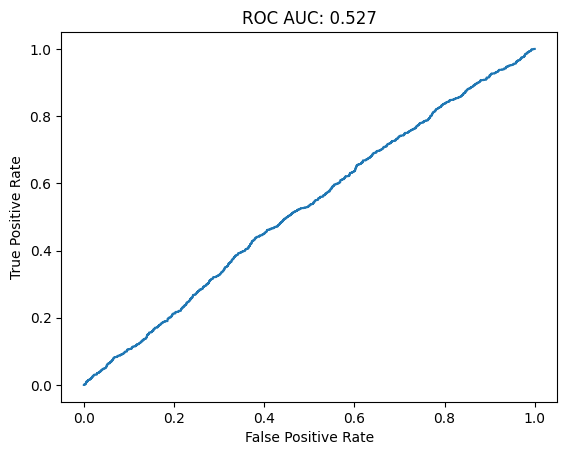

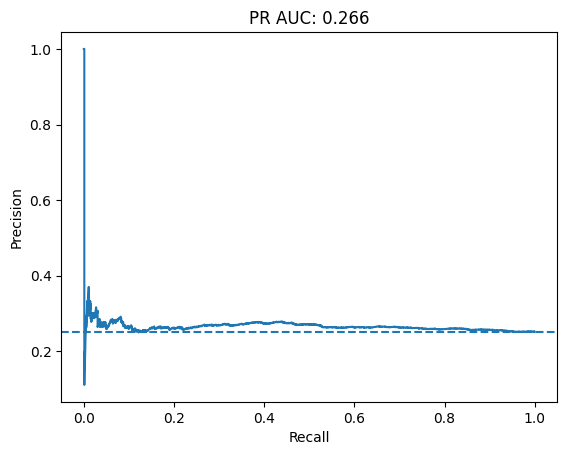

In [8]:
y_pred = best_svc.predict_proba(X_test_scaled)[:, 1]
prevalence = np.sum(y_test) / len(y_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_test, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
# f1 = f1_score(y_test, y_pred >= threshold)
# print("F1 score: ", f1)

# Random Forest Classification
Gilbert and his lab used elastic net linear regression - I tried this, but it just wasn't working. Random forest offers a more robust analysis and cares less about the scale of the features, but is more black box and harder to interpret.

## Fitting model

In [17]:
from sklearn.ensemble import RandomForestClassifier

# rf_class = RandomForestClassifier()

# params = {
#     "n_estimators": Integer(1, 500),
#     "max_depth": Integer(1, 100),
#     "min_samples_leaf": Real(0.0001, 0.99999, prior = "log-uniform")
# }

# grid_rf_class = BayesSearchCV(rf_class, params, scoring = "neg_mean_squared_error", n_jobs = -1, n_iter = 30, cv = 5, n_points = 5, verbose = 1)
# _ = grid_rf_class.fit(X_train_scaled, y_train)
# best_rf_class = grid_rf_class.best_estimator_
# joblib.dump(grid_rf_reg.best_estimator_, "models/RF.joblib", compress = ("lzma", 3))

best_rf_class = joblib.load("models/RF_class.joblib")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


## ROC curve (and other metrics)

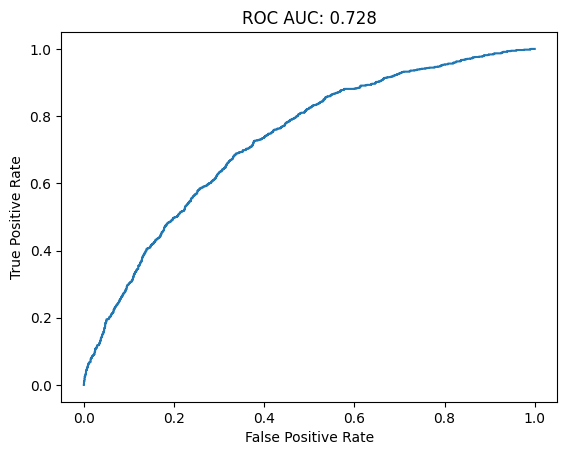

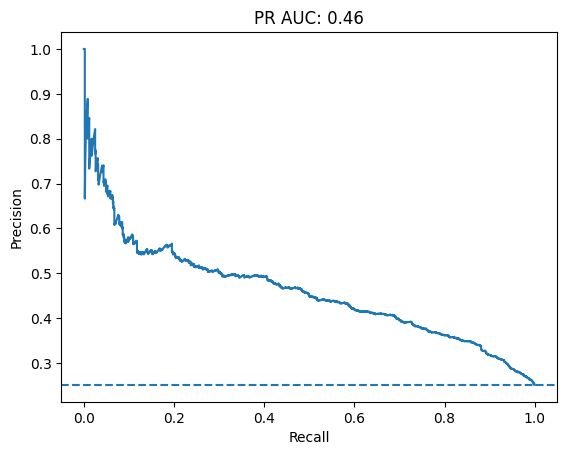

In [22]:
y_pred = best_rf_class.predict_proba(X_test_scaled)[:, 1]
prevalence = np.sum(y_test) / len(y_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_test, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
# f1 = f1_score(y_test, y_pred > threshold)
# print("F1 score: ", f1)

## Feature importances

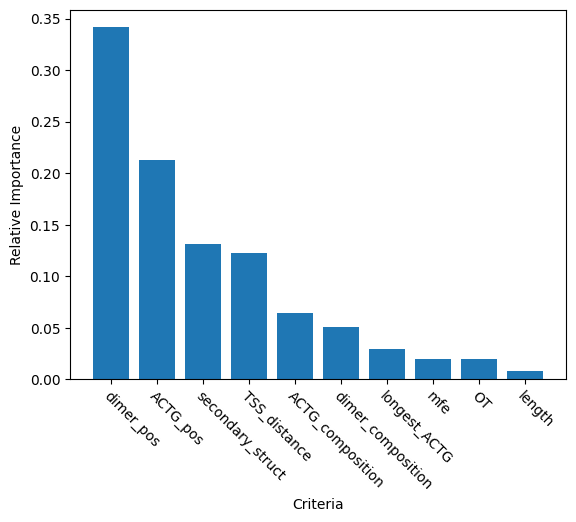

In [20]:
feature_imps = best_rf_class.feature_importances_
sum_imps = feature_imps.sum()
imp_df = pd.DataFrame({
    "title": imp_title,
    "importance": feature_imps / sum_imps
})
grouped_imp_df = imp_df.groupby("title").sum().reset_index().sort_values(by = "importance", ascending = False)

plt.figure()
plt.bar(grouped_imp_df["title"], grouped_imp_df["importance"])
plt.xticks(rotation = -45, ha = "left", rotation_mode = "anchor")
plt.xlabel("Criteria")
plt.ylabel("Relative Importance")
plt.show()

# Gradient Boosting Regression
Allegedly more robust than random forest regression.

## Fitting model

In [35]:
from lightgbm import LGBMClassifier

# lgbm_class = LGBMClassifier(verbose = 0)

# params = {
#     "n_estimators": Integer(50, 500),
#     "learning_rate": Real(0.001, 0.3, prior = "log-uniform"),
#     "num_leaves": Integer(2, 100),
#     "reg_lambda": Real(1, 1000, prior = "log-uniform"),
# }

# grid_lgbm_class = BayesSearchCV(lgbm_class, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
# _ = grid_lgbm_class.fit(X_train_scaled, y_train)
# best_lgbm_class = grid_lgbm_class.best_estimator_
# with open("models/LGBM_class.pk1", "wb") as file:
#     pickle.dump(best_lgbm_class, file)
    
with open("models/LGBM_class.pk1", "rb") as file:
    best_lgbm_class = pickle.load(file)

## ROC curve (and other metrics)

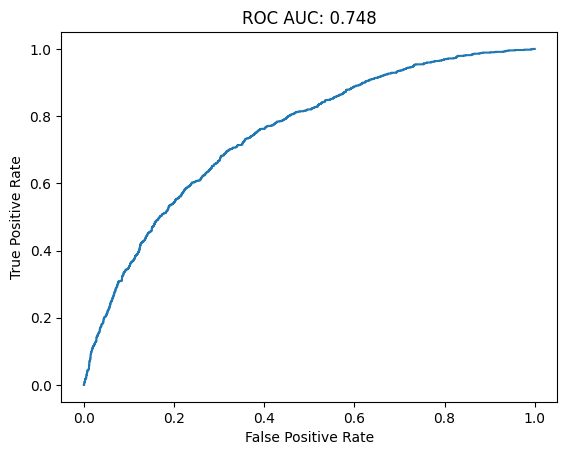

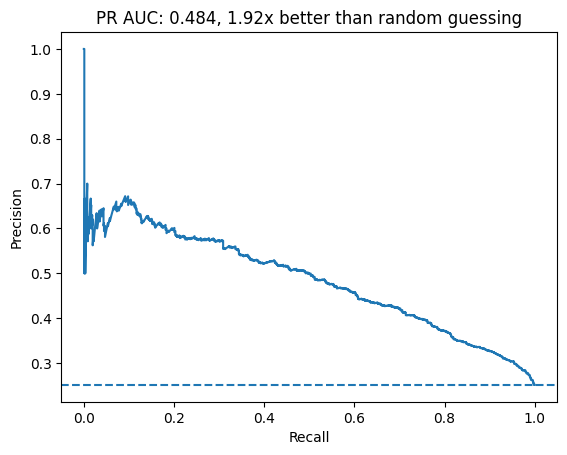

In [36]:
y_pred = best_lgbm_class.predict_proba(X_test_scaled)[:, 1]
prevalence = np.sum(y_test) / len(y_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_test, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)) + ", " + str(round(roc_pr / prevalence, 2)) + "x better than random guessing")
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
# f1 = f1_score(y_test, y_pred >= threshold)
# print("F1 score: ", f1)

## Feature importances

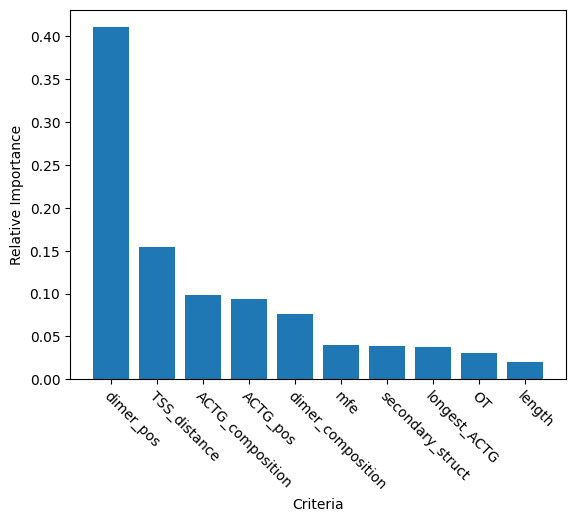

In [37]:
feature_imps = best_lgbm_class.feature_importances_
sum_imps = feature_imps.sum()
imp_df = pd.DataFrame({
    "title": imp_title,
    "importance": feature_imps / sum_imps
})
grouped_imp_df = imp_df.groupby("title").sum().reset_index().sort_values(by = "importance", ascending = False)

plt.figure()
plt.bar(grouped_imp_df["title"], grouped_imp_df["importance"])
plt.xticks(rotation = -45, ha = "left", rotation_mode = "anchor")
plt.xlabel("Criteria")
plt.ylabel("Relative Importance")
plt.show()